In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML

In [7]:
def getINFO(info_string):
        infolist = info_string.split(';')
        infodict = {}
        for kv in infolist:
                kv = kv.split('=')
                if len(kv) == 2:
                        k, v = kv
                        infodict[k] = v 
        return infodict

def match_allele_csq(Ref, Alts, csq_head, csq_string):
        # Trim Leading Base
        Alts = Alts.split(",")
        if len(list(set([x[0] for x in Alts])))==1 and Ref[0] == list(set([x[0] for x in Alts]))[0]:
                _Ref = Ref[1:] if len(Ref[1:]) >0 else "-" 
                _Alts = [Alt[1:] if len(Alt[1:]) >0 else "-" for Alt in Alts]
        else:
                _Alts = Alts
        res = {}
        csqs = csq_string.split(",")
        csqs = [dict(zip(csq_head, vep.split("|"))) for vep in csqs]
        for i, Alt in enumerate(Alts):
                res[Alt] = []
                for j, csq in enumerate(csqs):
                        if csq["Allele"] == _Alts[i]:
                                csq["Consequence"] = csq["Consequence"] .split("&")
                                res[Alt].append(csq)
        return res

Genes = ["ASXL3","CHD2","CHD8","DSCAM","DYRK1A","FOXP1","HIVEP2","SCN2A"]
def GetRelventCSQ(CSQs):
    for csq in CSQs:
        if csq["SYMBOL"] in Genes:
            return csq

In [16]:
LGD_class = set(["splice_acceptor_variant", "splice_donor_variant", "stop_gained",
                "stop_lost", "start_lost", "frameshift_variant"])

VCF = "/Users/jiayao/Work/BrainDisorders/src/unifiedmodel/VIP.RecGenes.VEP.vcf"
hand = open(VCF, 'rt')
outfil = csv.writer(open("VIP.RecGenes.tsv", 'wt'), delimiter="\t")
outfil.writerow(["Chr", "Pos", "ref", "Alt", "Gene", "cons", "AF", "sample", "GT"])
for l in hand:
    if l.startswith("##"):
        if l.startswith("##INFO=<ID=CSQ"):
            CSQ_header = l.strip().split("Format: ")[1].rstrip('>\"').split("|")
        continue
    elif l.startswith("#C"):
        header = l.strip().split("\t")
        samples = header[9:]
        continue
    llist = l.strip().split("\t")
    genotypes = llist[9:]
    #if llist[6] != "PASS":
    #    continue
    Chr, Pos, ID, ref, alts = llist[0:5]
    INFO_string = llist[7]
    infodict = getINFO(llist[7])
    Allele_CSQ_dict = match_allele_csq(ref, alts, CSQ_header, infodict["CSQ"])
    for i,Alt in enumerate(alts.split(',')):
        vep = GetRelventCSQ(Allele_CSQ_dict[Alt])
        cons = vep["Consequence"]
        AF = vep["gnomAD_AF"]
        Gene = vep["SYMBOL"]
        if len(set(cons).intersection(LGD_class))>= 1:
            for j, GT in enumerate(genotypes):
                gt = GT.split(":")[0].split("/")
                if int(gt[1]) == i+1:
                    sample = samples[j]
                    outfil.writerow([Chr, Pos, ref, Alt, Gene, cons, AF, sample, GT])

In [409]:
# VABS, VIQ, NVIQ
VABS_df = pd.read_csv("/Users/jiayao/Work/BrainDisorders/VIP_phenotype/SSC_PhenotypeV15.2/Proband_Data/ssc_proband_vineland_ii.csv")
VABS_df.head()
scores = VABS_df["composite_standard_score"].values
fams = VABS_df["individual"].values
fams = [int(x.split(".")[0]) for x in fams]
indv2vabs = dict(zip(fams, scores))
core_desc = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/VIP_phenotype/SSC_PhenotypeV15.2/Proband_Data/ssc_core_descriptive.csv")
core_desc = core_desc[["individual", "ssc_diagnosis_full_scale_iq",
                       "ssc_diagnosis_nonverbal_iq", "ssc_diagnosis_verbal_iq"]]
core_desc["familyId"] = core_desc.apply(lambda row:int(row["individual"].split(".")[0]), axis=1)
#display(core_desc.head(2))
core_desc.columns.values
famID2FSIQ = dict(zip(core_desc["familyId"].values, core_desc["ssc_diagnosis_full_scale_iq"].values))


In [358]:
LGD_DF = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProLGD.xlsx")
LGD_fams = set(LGD_DF["familyId"].values)

In [410]:
wigler_fam_info = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/Supplementary_Table_1.xlsx")
#wigler_fam_info = wigler_fam_info[wigler_fam_info["familyId"].isin(LGD_fams)]
wigler_fam_info["VIQ"] = wigler_fam_info["probandVIQ"]
wigler_fam_info["NVIQ"] = wigler_fam_info["probandNVIQ"]
wigler_fam_info = wigler_fam_info[["familyId", "VIQ", "NVIQ"]]
wigler_fam_info["VABS"] = wigler_fam_info.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
wigler_fam_info["FSIQ"] = wigler_fam_info.apply(lambda row:famID2FSIQ.get(row["familyId"], np.nan), axis=1)
wigler_fam_info = wigler_fam_info.dropna(axis=0)
wigler_fam_info.head()

,familyId,VIQ,NVIQ,VABS,FSIQ
0,11542,121.0,102.0,82.0,109.0
1,13736,119.0,112.0,82.0,118.0
2,13735,30.0,27.0,59.0,28.0
3,13734,36.0,51.0,60.0,43.0
4,11546,100.0,123.0,76.0,99.0


In [448]:
#SameExonIQ
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
#Jiayao_features = pd.read_csv("unifiedmodel/SSC.LGD.features.csv")
Jiayao_features = Jiayao_features.dropna()
#Jiayao_features["VABS"] = Jiayao_features.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
ExonCount = Jiayao_features.groupby("ExonID")["ExonID"].count()
Jiayao_features["ExonCount"] = Jiayao_features.apply(lambda row: ExonCount[row["ExonID"]], axis=1)
SameExon = Jiayao_features[Jiayao_features["ExonCount"]>=2]
SameExonFSIQ_diff, SameExonVIQ_diff, SameExonNVIQ_diff, SameExonVABS_diff = [], [], [], []
for exon in list(set(SameExon['ExonID'].values)):
    tmpdf = SameExon[SameExon["ExonID"]==exon]
    FSIQs = tmpdf["FSIQ"].values
    VIQs = tmpdf["VIQ"].values
    NVIQs = tmpdf["NVIQ"].values
    VABSs = tmpdf["VABS"].values
    SameExonFSIQ_diff.append(abs(FSIQs[0]-FSIQs[1]))
    SameExonVIQ_diff.append(abs(VIQs[0]-VIQs[1]))
    SameExonNVIQ_diff.append(abs(NVIQs[0]-NVIQs[1]))
    SameExonVABS_diff.append(abs(VABSs[0]-VABSs[1]))

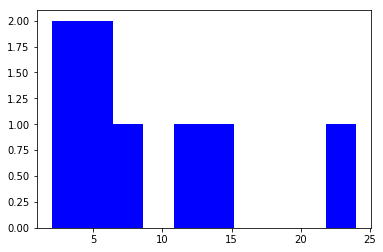

8.875 17.25 8.25 6.875
[2.0, 5.0, 13.0, 6.0, 2.0, 12.0, 7.0, 24.0]


In [450]:
plt.hist(SameExonFSIQ_diff, color="b")
plt.show()
print(np.mean(SameExonFSIQ_diff), np.mean(SameExonVIQ_diff), np.mean(SameExonNVIQ_diff), np.mean(SameExonVABS_diff))
print(SameExonFSIQ_diff)

In [451]:
wigler_fam_info.shape

(2447, 5)

In [452]:
#spearmanr
print("FSIQ - NVIQ", spearmanr(Jiayao_features["FSIQ"].values, Jiayao_features["NVIQ"].values))
print("NVIQ - VIQ", spearmanr(Jiayao_features["NVIQ"].values, Jiayao_features["VIQ"].values))
print("NVIQ - VABS", spearmanr(Jiayao_features["NVIQ"].values, Jiayao_features["VABS"].values))
print("VIQ - VABS", spearmanr(Jiayao_features["VIQ"].values, Jiayao_features["VABS"].values))

FSIQ - NVIQ SpearmanrResult(correlation=0.9342595105809813, pvalue=1.8506327408929986e-29)
NVIQ - VIQ SpearmanrResult(correlation=0.7778375934610625, pvalue=4.001480689180422e-14)
NVIQ - VABS SpearmanrResult(correlation=0.40078397886038913, pvalue=0.001031391754137568)
VIQ - VABS SpearmanrResult(correlation=0.47804323290665063, pvalue=6.470901086579776e-05)


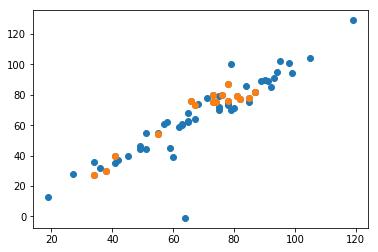

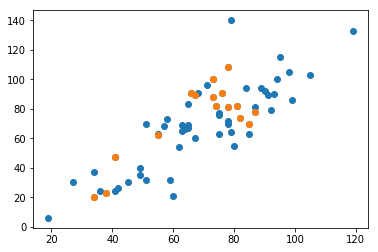

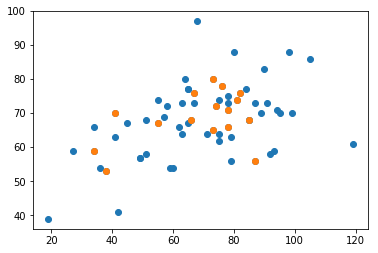

In [453]:
plt.scatter(Jiayao_features["NVIQ"].values, Jiayao_features["FSIQ"].values)
plt.scatter(SameExon["NVIQ"].values, SameExon["FSIQ"].values)
plt.show()
plt.scatter(Jiayao_features["NVIQ"].values, Jiayao_features["VIQ"].values)
plt.scatter(SameExon["NVIQ"].values, SameExon["VIQ"].values)
plt.show()
plt.scatter(Jiayao_features["NVIQ"].values, Jiayao_features["VABS"].values)
plt.scatter(SameExon["NVIQ"].values, SameExon["VABS"].values)
plt.show()

In [429]:
print("NVIQ - VIQ", spearmanr(wigler_fam_info["NVIQ"].values, wigler_fam_info["VIQ"].values))
print("NVIQ - VABS", spearmanr(wigler_fam_info["NVIQ"].values, wigler_fam_info["VABS"].values))
print("VIQ - VABS", spearmanr(wigler_fam_info["VIQ"].values, wigler_fam_info["VABS"].values))

NVIQ - VIQ SpearmanrResult(correlation=0.8068233401628775, pvalue=0.0)
NVIQ - VABS SpearmanrResult(correlation=0.6445558299435186, pvalue=2.166292752853856e-287)
VIQ - VABS SpearmanrResult(correlation=0.6438881506038413, pvalue=1.3090126010331068e-286)


In [456]:
import itertools
ALL_FSIQ_diff = []
ALL_VIQ_diff = []
ALL_NVIQ_diff = []
ALL_VABS_diff = []
SE_FSIQ_diff = []
SE_VIQ_diff = []
SE_NVIQ_diff = []
SE_VABS_diff = []
for row1, row2 in itertools.combinations(Jiayao_features.iterrows(), r=2):
    row1 = row1[1]
    row2 = row2[1]
    FSIQ_diff = abs(row1["FSIQ"]- row2["FSIQ"])
    NVIQ_diff = abs(row1["NVIQ"]- row2["NVIQ"])
    VIQ_diff = abs(row1["VIQ"]- row2["VIQ"])
    VABS_diff = abs(row1["VABS"]- row2["VABS"])
    if row1["ExonID"] == row2["ExonID"]:
        SE_FSIQ_diff.append(FSIQ_diff)
        SE_VIQ_diff.append(VIQ_diff)
        SE_NVIQ_diff.append(NVIQ_diff)
        SE_VABS_diff.append(VABS_diff)
    else:
        ALL_FSIQ_diff.append(FSIQ_diff)
        ALL_VIQ_diff.append(VIQ_diff)
        ALL_NVIQ_diff.append(NVIQ_diff)
        ALL_VABS_diff.append(VABS_diff)

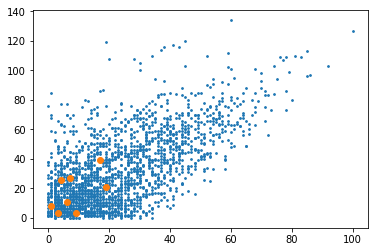

In [460]:
plt.scatter(ALL_NVIQ_diff, ALL_VIQ_diff, s=3)
plt.scatter(SE_NVIQ_diff, SE_VIQ_diff)
plt.show()

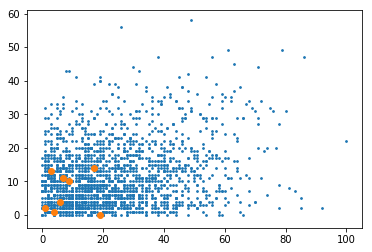

In [461]:
plt.scatter(ALL_NVIQ_diff, ALL_VABS_diff, s=3)
plt.scatter(SE_NVIQ_diff, SE_VABS_diff)
plt.show()

In [441]:
import itertools
sampled_FSIQ_diff = []
sampled_VIQ_diff = []
sampled_NVIQ_diff = []
sampled_VABS_diff = []
Mean_FSIQ_diff, Mean_VIQ_diff, Mean_NVIQ_diff, Mean_VABS_diff = [],[],[],[]
N,i = 0, 0
for row1, row2 in itertools.combinations(Jiayao_features.iterrows(), r=2):
    row1 = row1[1]
    row2 = row2[1]
    #NVIQ_diff = abs(row1["probandNVIQ"]- row2["probandNVIQ"])
    #VIQ_diff = abs(row1["probandVIQ"]- row2["probandVIQ"])
    FSIQ_diff = abs(row1["FSIQ"]- row2["FSIQ"])
    NVIQ_diff = abs(row1["NVIQ"]- row2["NVIQ"])
    VIQ_diff = abs(row1["VIQ"]- row2["VIQ"])
    VABS_diff = abs(row1["VABS"]- row2["VABS"])
    if FSIQ_diff <= 20 and FSIQ_diff >= 0:
        if i >= 8:
            #if np.mean(sampled_FSIQ_diff) > 5 and np.mean(sampled_FSIQ_diff) < 10:
            if np.mean(sampled_FSIQ_diff) > 8.8 and np.mean(sampled_FSIQ_diff) < 8.9:
                N += 1
                Mean_FSIQ_diff.append(np.mean(sampled_FSIQ_diff))
                Mean_VIQ_diff.append(np.mean(sampled_VIQ_diff))
                Mean_NVIQ_diff.append(np.mean(sampled_NVIQ_diff))
                Mean_VABS_diff.append(np.mean(sampled_VABS_diff))
            sampled_FSIQ_diff = []
            sampled_VIQ_diff = []
            sampled_NVIQ_diff = []
            sampled_VABS_diff = []
            i = 0
        sampled_FSIQ_diff.append(FSIQ_diff)
        sampled_NVIQ_diff.append(NVIQ_diff)
        sampled_VIQ_diff.append(VIQ_diff)
        sampled_VABS_diff.append(VABS_diff)
        i += 1
    if N > 1000:
        break
#print(np.mean(sampled_VIQ_diff), np.mean(sampled_NVIQ_diff))

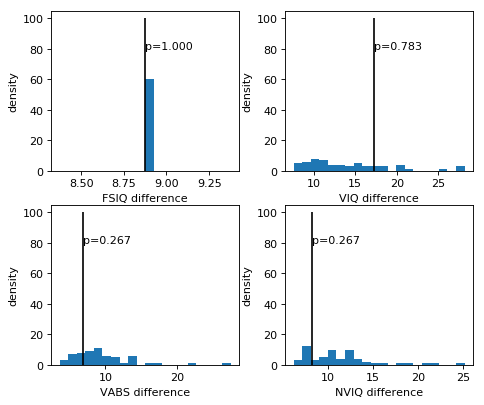

In [443]:
def get_smaller_P(xline, dist):
    count = 0
    for i,v in enumerate(dist):
        if xline >= v:
            count += 1
    return float(count)/len(dist)

fig, axs = plt.subplots(2,2,figsize=(6,5), dpi=80,)
axs = axs.flatten()
fig.tight_layout()
features = [('FSIQ', 8.875, Mean_FSIQ_diff), ('VIQ', 17.25, Mean_VIQ_diff), 
            ('VABS', 6.875, Mean_VABS_diff), ('NVIQ', 8.25, Mean_NVIQ_diff)]
for ax,feature in zip(axs, features):  
    label, xline, dist = feature
    p = get_smaller_P(xline, dist)
    ax.hist(dist, bins=20)
    ax.vlines(x=xline, ymin=0, ymax=100)
    ax.text(x=xline, y=80, s="p=%.3f"%p)
    ax.set_ylabel("density")
    ax.set_xlabel("%s difference"%(label))
#plt.show()

In [252]:
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
#Jiayao_features.head(2)
tmpdf = Jiayao_features.drop_duplicates(subset="ExonID", keep='first')
print(tmpdf.shape)
r, p = pearsonr(np.array(tmpdf["phyloP100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)
r, p = pearsonr(np.array(tmpdf["phastCons100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)

(57, 30)
-0.2777379737839482 0.03645927041594309
-0.23583164454164451 0.07738797045741304


In [126]:
# conservation scores
# Same gene highest phyloP score set similarity 
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
Jiayao_features["VABS"] = Jiayao_features.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
ExonCount = Jiayao_features.groupby("ExonID")["ExonID"].count()
Jiayao_features["ExonCount"] = Jiayao_features.apply(lambda row: ExonCount[row["ExonID"]], axis=1)
DiffExon = Jiayao_features[Jiayao_features["ExonCount"]<2]
DiffExonVIQ_diff, DiffExonNVIQ_diff, DiffExonVABS_diff = [], [], []
for gene in list(set(DiffExon['effectGene'].values)):
    #print(gene)
    tmpdf = DiffExon[DiffExon["effectGene"]==gene]
    tmpdf = tmpdf.sort_values('phyloP100way', ascending=False)
    if tmpdf.shape[0] < 2:
        continue
    #display(tmpdf)
    phyloPs = tmpdf["phyloP100way"].values
    phyloP_diff = phyloPs[0] - phyloPs[1]
    #print(phyloP_diff)
    if phyloP_diff > 1:
        continue
    VIQs = tmpdf["VIQ"].values
    NVIQs = tmpdf["NVIQ"].values
    VABSs = tmpdf["VABS"].values
    DiffExonVIQ_diff.append(abs(VIQs[0]-VIQs[1]))
    DiffExonNVIQ_diff.append(abs(NVIQs[0]-NVIQs[1]))
    DiffExonVABS_diff.append(abs(VABSs[0]-VABSs[1]))

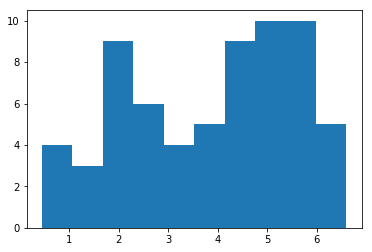

In [127]:
plt.hist(Jiayao_features["phyloP100way"].values)
plt.show()

8 11


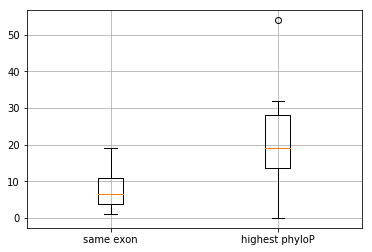

6.5 19.0
MannwhitneyuResult(statistic=19.5, pvalue=0.023657174348709568)


In [181]:
print(len(SameExonNVIQ_diff), len(DiffExonNVIQ_diff))
plt.boxplot([SameExonNVIQ_diff, DiffExonNVIQ_diff],
            labels = ["same exon", "highest phyloP"])
plt.grid(True)
plt.show()
print(np.median(SameExonNVIQ_diff), np.median(DiffExonNVIQ_diff))
print(scipy.stats.mannwhitneyu(SameExonNVIQ_diff, DiffExonNVIQ_diff, alternative="less"))

In [604]:
RecGenes = ["ASXL3","CHD2","CHD8","DSCAM","DYRK1A","FOXP1","HIVEP2","SCN2A","ADNP","CHAMP1","CSNK2A1","GRIN2B",
        "HNRNPH2","MED13L","PACS1","PPP2R5D","SETBP1","STXBP1","SYNGAP1"]
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
df = Jiayao_features[Jiayao_features["effectGene"].isin(Genes)]
for i, row in df.iterrows():
    df.loc[i, "sfari_id"] = df.loc[i, "familyId"]
    df.loc[i, "sex"] = df.loc[i, "gender"]
    Chr, Pos, Ref, Alt = row["vcfVariant"].split(":")
    Len = max(0, len(Ref) - len(Alt))
    df.loc[i, "location"] = "{}:{}-{}".format(Chr, Pos, int(Pos)+Len)
    df.loc[i, "inheritance_status"] = "de-novo"
    df.loc[i, "genetic_status"] = row["effectGene"]
    df.loc[i, "composite_standard_score"] = row["VABS"]
df = df[["sfari_id","sex","genetic_status","inheritance_status","composite_standard_score","location"]]

/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [605]:
df.head(2)

,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location
0,13545.0,M,ADNP,de-novo,53.0,20:49509094-49509094
1,12130.0,F,ADNP,de-novo,67.0,20:49510027-49510029


In [606]:
VIP_VABS = pd.read_csv("unifiedmodel/vip.recgenes.withlocation.csv")
VIP_VABS.head(2)

,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location
0,15710-x1,M,ASXL3,de-novo,75.0,18:31323776-31323776
1,16159-x1,F,ASXL3,de-novo,37.0,18:31319345-31319349


In [607]:
sfari_id2vabs = {}
for sfari_id in VIP_VABS["sfari_id"].values:
    #print(sfari_id)
    tmpdf = VIP_VABS[VIP_VABS["sfari_id"]==sfari_id]
    vabs = np.mean(tmpdf["composite_standard_score"].values)
    sfari_id2vabs[sfari_id] = vabs

In [608]:
print(VIP_VABS.shape)
VIP_VABS = VIP_VABS.drop_duplicates(subset="sfari_id", keep="first")
#VIP_VABS.head(2)
print(VIP_VABS.shape)
VIP_VABS["composite_standard_score"] = VIP_VABS.apply(lambda row:sfari_id2vabs[row["sfari_id"]], axis=1)

(123, 6)
(89, 6)


In [609]:
VABS = pd.concat([df, VIP_VABS])
VABS = VABS[VABS["inheritance_status"]=="de-novo"]
#VABS = VABS.dropna()
VABS = VABS.reset_index(drop=True)

In [610]:
VABS.to_csv("unifiedmodel/SSC_VIP_VABS_RecLGD.csv", index="False")

In [611]:
Gene2Trans = {}
"""
hand = open("unifiedmodel/VIPgenes.gencode.v19.gtf", 'rt')
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "transcript" and info["transcript_type"] == "protein_coding":
        if info["gene_name"] not in Gene2Trans:
            Gene2Trans[info["gene_name"]] = (info["transcript_id"], abs(start - end))
        else:
            if abs(start-end) > Gene2Trans[info["gene_name"]][1]:
                Gene2Trans[info["gene_name"]] = (info["transcript_id"], abs(start - end))
"""
Gene2Trans["ASXL3"]="ENST00000269197.5"
Gene2Trans["CHD8"]="ENST00000399982.2"
Gene2Trans["DYRK1A"]="ENST00000339659.4"
Gene2Trans["CHD2"]="ENST00000394196.4"
Gene2Trans["SCN2A"]="ENST00000357398.3"
Gene2Trans["FOXP1"]="ENST00000318789.4"
Gene2Trans["HIVEP2"]="ENST00000367603.2"
Gene2Trans["PPP2R5D"]="ENST00000485511.1"
Gene2Trans["HIVEP2"]="ENST00000367603.2"
Gene2Trans["SYNGAP1"]="ENST00000418600.2"
Gene2Trans["STXBP1"]="ENST00000373302.3"
Gene2Trans["PACS1"]="ENST00000320580.4"
Gene2Trans["MED13L"]="ENST00000281928.3"
Gene2Trans["CHAMP1"]="ENST00000361283.1"
Gene2Trans["SETBP1"]="ENST00000282030.5"
Gene2Trans["CSNK2A1"]="ENST00000217244.3"
Gene2Trans["ADNP"]="ENST00000396029.3"
Gene2Trans["DSCAM"]="ENST00000400454.1"
Gene2Trans["HNRNPH2"]="ENST00000400454.1"
Gene2Trans["GRIN2B"]="ENST00000609686.1"
print (Gene2Trans)
selectedTrans = []
for k,v in Gene2Trans.items():
    selectedTrans.append(v)
print(selectedTrans)

{'ASXL3': 'ENST00000269197.5', 'CHD8': 'ENST00000399982.2', 'DYRK1A': 'ENST00000339659.4', 'CHD2': 'ENST00000394196.4', 'SCN2A': 'ENST00000357398.3', 'FOXP1': 'ENST00000318789.4', 'HIVEP2': 'ENST00000367603.2', 'PPP2R5D': 'ENST00000485511.1', 'SYNGAP1': 'ENST00000418600.2', 'STXBP1': 'ENST00000373302.3', 'PACS1': 'ENST00000320580.4', 'MED13L': 'ENST00000281928.3', 'CHAMP1': 'ENST00000361283.1', 'SETBP1': 'ENST00000282030.5', 'CSNK2A1': 'ENST00000217244.3', 'ADNP': 'ENST00000396029.3', 'DSCAM': 'ENST00000400454.1', 'HNRNPH2': 'ENST00000400454.1', 'GRIN2B': 'ENST00000609686.1'}
['ENST00000269197.5', 'ENST00000399982.2', 'ENST00000339659.4', 'ENST00000394196.4', 'ENST00000357398.3', 'ENST00000318789.4', 'ENST00000367603.2', 'ENST00000485511.1', 'ENST00000418600.2', 'ENST00000373302.3', 'ENST00000320580.4', 'ENST00000281928.3', 'ENST00000361283.1', 'ENST00000282030.5', 'ENST00000217244.3', 'ENST00000396029.3', 'ENST00000400454.1', 'ENST00000400454.1', 'ENST00000609686.1']


In [612]:
Genes = {}
hand = open("unifiedmodel/VIPgenes.gencode.v19.gtf", 'rt')
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "gene":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        Genes[gene_name] = GTFGene(gene_name, gene_id, strand)
    elif llist[2] == "transcript":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_id not in Genes[gene_name].Transcripts and transcript_type=="protein_coding" and transcript_id in selectedTrans:
            Genes[gene_name].Transcripts[transcript_id] = GTFTranscript(gene_name, transcript_name, transcript_id, strand)
    elif llist[2] == "exon":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        exon_id = info["exon_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_type=="protein_coding" and transcript_id in selectedTrans:
            exon= GTFExon(exon_id, start, end, transcript_id, strand)
            Genes[gene_name].Transcripts[transcript_id].Exons.append(exon)

In [613]:
exon_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv")
exon_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv")
cds_dict = loaddict()
display(exon_exp_col.head(2))
display(exon_exp_row.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip
1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863


In [614]:
def searchExon(Gene, Location, Genes):
    Chr, interval = Location.split(":")
    Start, End = interval.split("-")
    Pos, LenV = int(Start), int(End)-int(Start)
    gene_obj = Genes[Gene]
    _Exons, Transcripts = [],[]
    #print(Location, Pos, LenV)
    islej = "F"
    for transid, transobj in gene_obj.Transcripts.items():
        if transid not in selectedTrans:
            continue
        for exon in transobj.Exons:
            if Pos > exon.start -3 and Pos < exon.end +3:
                _Exons.append(exon.ExonID)
                Transcripts.append(transid)
                break
            elif LenV > 0:
                if (Pos < exon.start-3 and Pos + LenV > exon.start ) or (Pos < exon.end and Pos + LenV > exon.end +3):
                    _Exons.append(exon.ExonID)
                    Transcripts.append(transid)
                    break
    for transid, transobj in gene_obj.Transcripts.items():
        if len(transobj.Exons) >= 2:
            interval1, interval2 = transobj.LastExonJunction()
            if Gene=="CHD2":
                print(interval1, interval2)
            if (Pos > interval1[0] and Pos < interval1[1]):
                islej = "T"
            elif (Pos > interval2[0] and Pos < interval2[1]):
                islej = "T"
    if len(list(set(_Exons))) == 0:
        return "NA", "NA", "NA"
    else:
        return list(set(_Exons))[0], list(set(Transcripts))[0], islej


VABS["Exons"] = ""
VABS["Transcripts"] = ""

for i, row in VABS.iterrows():
    famid, gene, location = row["sfari_id"], row["genetic_status"], row["location"]
    ExonIDs, TranscriptIDs, islej = searchExon(gene, location, Genes)
    VABS.at[i, "Exons"] = ExonIDs
    VABS.at[i, "Transcripts"] = TranscriptIDs
    VABS.at[i, "isLEJ"] = islej

(93567602, 93571237) (93563433, 93563488)
(93567602, 93571237) (93563433, 93563488)
(93567602, 93571237) (93563433, 93563488)


In [635]:
VABS2 = VABS[VABS["isLEJ"]=="T"]
VABS.head(2)
#VABS2

,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location,Exons,Transcripts,isLEJ
0,13545,M,ADNP,de-novo,53.0,20:49509094-49509094,ENSE00001455631.1,ENST00000396029.3,T
1,12130,F,ADNP,de-novo,67.0,20:49510027-49510029,ENSE00001455631.1,ENST00000396029.3,T


In [628]:
res = {}
for gene in RecGenes:
    res[gene] = {}
    res[gene]["SameExon"] = []
    res[gene]["SameExonSameGender"] = []
    res[gene]["DiffExon"] = []
    df = VABS[VABS["genetic_status"]==gene]
    for row1, row2 in itertools.combinations(df.iterrows(), r=2):
        row1,row2 = row1[1], row2[1]
        score1 = row1["composite_standard_score"]
        score2 = row2["composite_standard_score"]
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            res[gene]["SameExon"].append( abs(score1-score2) )
            if row1["sex"] == row2["sex"]:
                res[gene]["SameExonSameGender"].append( abs(score1-score2) )
        else:
            res[gene]["DiffExon"].append( abs(score1-score2) )

In [634]:
SameExonMeans, DiffExonMeans, SameExonSameGenderMeans, DiffExonMeans2 = [],[],[],[]
for gene in RecGenes:
    #if gene=="FOXP1":
    #    continue
    SameExon = res[gene]["SameExon"]
    SameExonSameGender = res[gene]["SameExonSameGender"]
    DiffExon = res[gene]["DiffExon"]
    if len(SameExon) == 0 or len(DiffExon) == 0:
        continue
    SameExonMeans.append(np.mean(SameExon))
    DiffExonMeans.append(np.mean(DiffExon))
    if len(SameExonSameGender) != 0:
        SameExonSameGenderMeans.append(np.mean(SameExonSameGender))
        DiffExonMeans2.append(np.mean(DiffExon))
    print("%s\t%.2f\t%d\t%.2f\t%d\t%.2f\t%d"%(gene, np.mean(SameExon), len(SameExon), np.mean(SameExonSameGender), 
                                    len(SameExonSameGender), np.mean(DiffExon), len(DiffExon)))
print(SameExonMeans, DiffExonMeans)
print(scipy.stats.wilcoxon(SameExonMeans, DiffExonMeans))
print(scipy.stats.wilcoxon(SameExonSameGenderMeans, DiffExonMeans2))

ASXL3	14.14	21	15.25	15	15.89	77
CHD2	2.00	1	2.00	1	18.00	2
CHD8	11.00	1	nan	0	12.75	20
DSCAM	1.00	1	1.00	1	12.50	2
DYRK1A	12.33	6	13.33	3	17.23	22
HIVEP2	5.67	3	8.50	1	16.00	7
SCN2A	9.88	8	5.87	5	13.59	128
[14.142857142857142, 2.0, 11.0, 1.0, 12.333333333333334, 5.666666666666667, 9.875] [15.886363636363637, 18.0, 12.75, 12.5, 17.227272727272727, 16.0, 13.591145833333334]
WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)


/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [632]:
print(scipy.stats.mannwhitneyu(res["SCN2A"]["SameExon"], res["SCN2A"]["DiffExon"]))
print(scipy.stats.mannwhitneyu(res["ASXL3"]["SameExon"], res["ASXL3"]["DiffExon"]))
print(scipy.stats.mannwhitneyu(res["DYRK1A"]["SameExon"], res["DYRK1A"]["DiffExon"]))
print(scipy.stats.mannwhitneyu(res["HIVEP2"]["SameExon"], res["HIVEP2"]["DiffExon"]))

MannwhitneyuResult(statistic=389.0, pvalue=0.12851657456275456)
MannwhitneyuResult(statistic=766.5, pvalue=0.3596397270284283)
MannwhitneyuResult(statistic=53.0, pvalue=0.24077074348902505)
MannwhitneyuResult(statistic=0.0, pvalue=0.011327247040044673)


In [600]:
VABS[VABS["genetic_status"]=="CHD2"]

,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location,Exons,Transcripts,isLEJ
2,13618,F,CHD2,de-novo,57.0,15:93524060-93524064,ENSE00001097780.1,ENST00000394196.4,F
3,13614,M,CHD2,de-novo,74.0,15:93563244-93563244,ENSE00001517730.1,ENST00000394196.4,T
4,13818,M,CHD2,de-novo,76.0,15:93563282-93563282,ENSE00001517730.1,ENST00000394196.4,T
